In [20]:

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

In [21]:


import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [23]:

# import images
!cd /content
data_dir1 = '/content/sample_data/dataset/'
file_list1 = os.listdir(data_dir1)
image_paths = []
steering_angles = []
pattern = "*.jpg"


In [24]:
for filename in file_list1:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir1,filename))
        angle = int(float(filename[-8:-4]))
        steering_angles.append(angle)

image_path: /content/sample_data/dataset/frame01_0296_0143.jpg
steering_Angle: 143


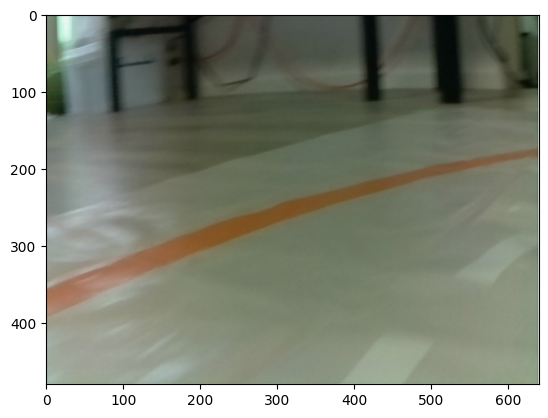

In [25]:

image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

In [27]:
df.head(15)

,ImagePath,Angle
0,/content/sample_data/dataset/frame01_0276_0142...,142
1,/content/sample_data/dataset/frame01_0153_0149...,149
2,/content/sample_data/dataset/frame01_0353_0150...,150
3,/content/sample_data/dataset/frame01_0315_0159...,159
4,/content/sample_data/dataset/frame01_0067_0125...,125
5,/content/sample_data/dataset/frame01_0293_0140...,140
6,/content/sample_data/dataset/frame01_0172_0149...,149
7,/content/sample_data/dataset/frame01_0139_0154...,154
8,/content/sample_data/dataset/frame01_0026_0094...,94
9,/content/sample_data/dataset/frame01_0361_0142...,142


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImagePath  328 non-null    object
 1   Angle      328 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [29]:
df.describe()

,Angle
count,328.000000
mean,130.615854
std,23.686381
min,88.000000
25%,106.000000
50%,140.000000
75%,150.250000
max,160.000000


In [36]:
labels = df.copy(deep=True)
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/sample_data/dataset/',
        x_col='ImagePath',
        y_col='Angle',
        target_size=(120, 160),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 328 validated image filenames.


In [37]:
features, target = next(train_gen_flow)
features.shape

(32, 120, 160, 3)

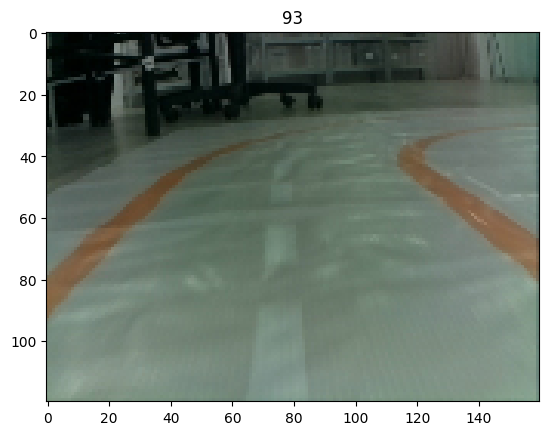

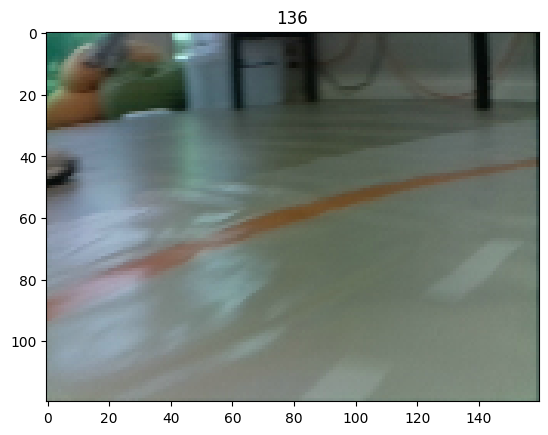

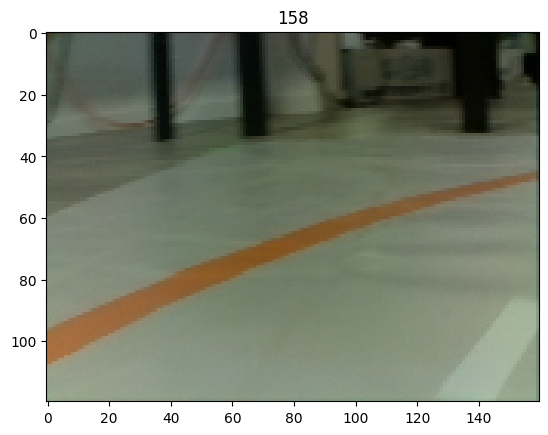

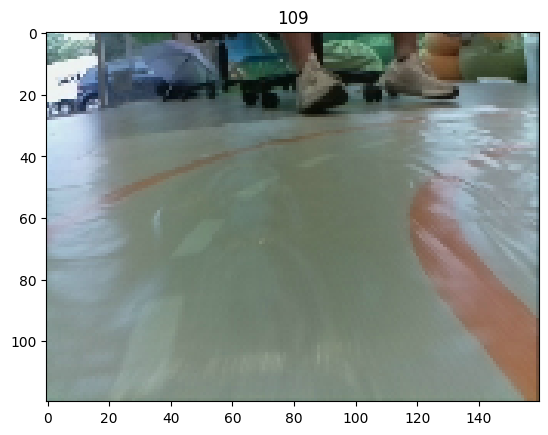

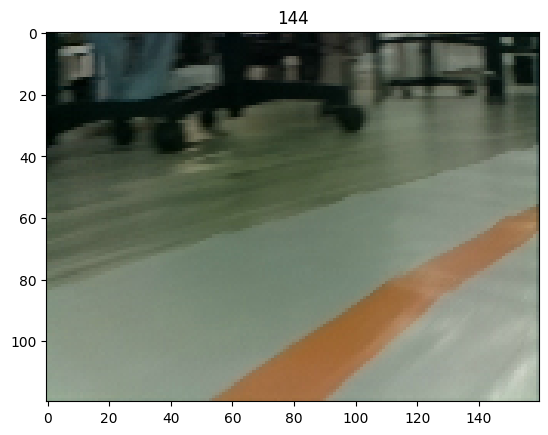

In [39]:
for i in range(5):
    plt.imshow(features[i])
    plt.title(target[i])
    plt.show()

In [46]:

def load_train(df):
    labels = df
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                       # horizontal_flip=True,
                                       # width_shift_range=0.2,
                                        validation_split=0.25)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/content/sample_data/dataset/',
        x_col='ImagePath',
        y_col='Angle',
        target_size=(120, 160),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

In [47]:
def load_test(df):
    labels = df
    test_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= '/content/sample_data/dataset/',
        x_col='ImagePath',
        y_col='Angle',
        target_size=(120, 160),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


In [53]:
def create_model(input_shape): #120, 160, 3
    backbone = ResNet50(input_shape=input_shape, weights='imagenet',
                        include_top=False)
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

In [49]:
def train_model(model, train_data, test_data, batch_size=None,
                epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [50]:
train = load_train(labels)


Found 246 validated image filenames.


In [51]:
test = load_test(labels)

Found 82 validated image filenames.


In [54]:
model = create_model(input_shape=(120, 160, 3))

In [55]:
train_model(model, train, test, batch_size=32)

Epoch 1/10
8/8 - 105s - loss: 17044.8809 - mae: 128.5770 - val_loss: 17622.8203 - val_mae: 130.4274 - 105s/epoch - 13s/step
Epoch 2/10
8/8 - 79s - loss: 14923.8291 - mae: 120.2370 - val_loss: 16639.4531 - val_mae: 126.5974 - 79s/epoch - 10s/step
Epoch 3/10
8/8 - 79s - loss: 12714.6221 - mae: 110.9877 - val_loss: 16798.3906 - val_mae: 127.2237 - 79s/epoch - 10s/step
Epoch 4/10
8/8 - 83s - loss: 10995.6602 - mae: 102.4170 - val_loss: 16596.0527 - val_mae: 126.4286 - 83s/epoch - 10s/step


KeyboardInterrupt: ignored